# Машинное обучение, DS-поток, осень 2022
## Задание 3.5


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание**

* Задача 1 &mdash; 20 баллов;
* Задача 2 &mdash; 20 баллов;
* Задача 3 &mdash; 40 баллов;
* Задача 4 &mdash; 120 баллов;
* Задача 5 &mdash; 30 баллов.

## Задача 1

Докажите, что критерий Джини равен вероятности ошибки случайного классификатора, который выдаёт предсказания с вероятностями пропорционально доле классов в выборке. 

## Задача 2

Пусть $X = (x_1, ..., x_n)$ &mdash; выборка объектов и $Y = (Y_1, ..., Y_n)$ &mdash; соответствующие значения вещественного отклика. Критерий информативности для набора объектов вычисляется на основе того, насколько хорошо их отклик предсказывается константой:

$$
H(X) = \min_{c \in Y} \dfrac{1}{n} \sum_{i=1}^n L(Y_i, c),
$$

где $L(y, c)$ &mdash; некоторая функция потерь. Соответственно, чтобы получить вид критерия при конкретной функции потерь, необходимо аналитически найти оптимальное значение константы и подставить его в формулу для $H(X)$.

Выведите критерии информативности для следующих функций потерь:
1. $L(y, c) = (y-c)^2$;
2. $L(y, c) = |y-c|$.

Найдите также оптимальное предсказание в листьях дерева.

## Задача 3

В случае задачи классификации рассматривается вероятностное предсказание, и критерий информативности имеет вид
$$H(X) = \min_{\stackrel{p_1, ..., p_K \in [0, 1]}{p_1+...+p_K=1}} \dfrac{1}{n} \sum_{i=1}^n L\left(Y_i, \{p_k\}\right).$$
Выведите и упростите критерии информативности, найдите оптимальные оценки вероятностей в листах для следующих функций потерь:
* $L(y, \{p_k\}) = \sum_{k=1}^K \left(p_k-I\{y=k\}\right)^2$;
* $L(y, \{p_k\}) = -\sum_{k=1}^K I\{ y=k\}\log p_k$.

## Задача 4

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_wine
from sklearn.datasets import load_boston
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)
plt.rcParams['axes.facecolor'] = 'lightgrey'

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $\frac{|X_l|}{|X_m|} * H(X_l) + \frac{|X_r|}{|X_m|} * H(X_r)$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** Нужно оценивать величину разброса таргета в вершине и находить аргументы, при которых она достигает минимума. То есть мы хотим разбить вершину так, чтобы полученные две вершины были более однородны по таргетам.


Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy` — массив размерности `(n,)` из значений отклика.

In [2]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    return np.sum((y - np.mean(y))**2) / len(y)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    return np.sum(abs(y - np.median(y))) / len(y)


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''
    
    unique, counts = np.unique(y, return_counts=True)

    return (counts / len(y))


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    p_k = get_probs_by_y(y)
    
    return np.sum(p_k * (1 - p_k))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    
    p_k = get_probs_by_y(y)
    
    return -np.sum(p_k * np.log(p_k))

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [4]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [5]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


* `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,
* `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,
* `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

* `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

* `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

* `predict` — получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.
* `predict_proba_instance` — предсказание распределения вероятностей по классам для одного элемента выборки, 
* `predict_proba` — предсказание распределения вероятностей по классам для всех элементов выборки,
* `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** Будем рассматривать в качестве пороговых все значения, которые принимал соответствующий признак. Другие рассмтаривать не имеет смысла, тк нового разбиения мы не получим.

**Структура решающего дерева**


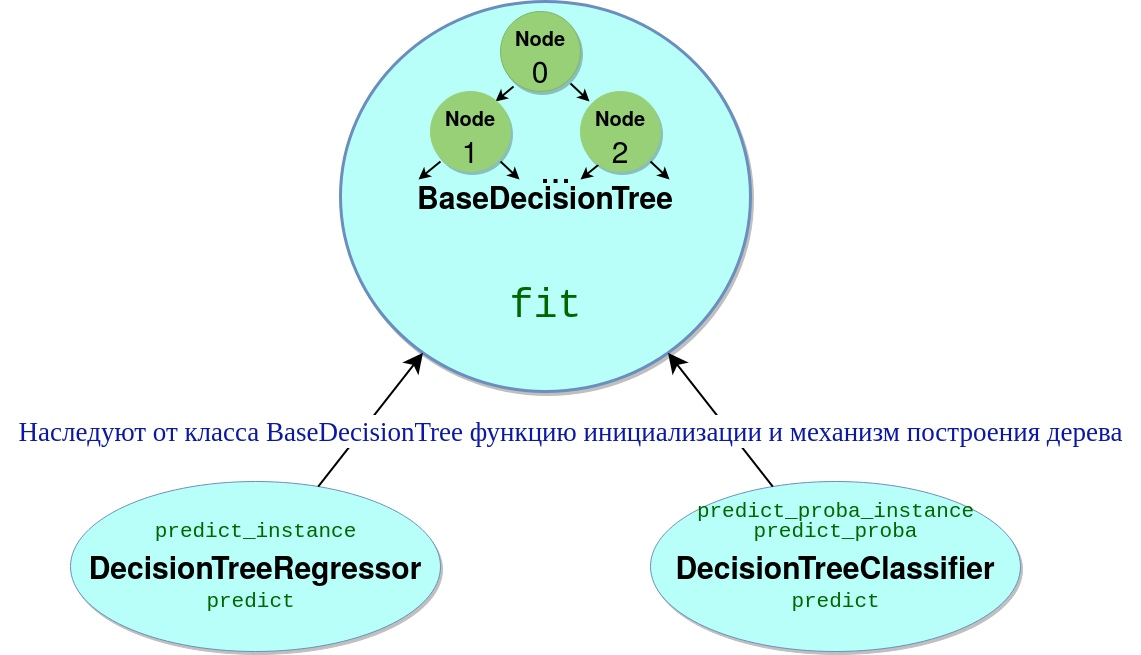

In [6]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold

        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None

        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0

        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]

        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1

        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета
        # (они будут нашими порогами).
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        if depth == self.max_depth or len(y) < self.min_samples_split:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, 'set_class_count', None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        min_functional = np.inf
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                X_l = y[X[:, feature_id] < threshold]
                X_r = y[X[:, feature_id] >= threshold]
                if (len(X_r) == 0 or len(X_l) == 0):
                    continue
                functional_value = len(X_l) / len(X) * self.criterion(X_l) + len(X_r) / len(X) * self.criterion(X_r)
                if functional_value < min_functional:
                    min_functional = functional_value
                    best_feature = feature_id
                    best_threshold = threshold
            
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        
        # разделим выборку на 2 части по порогу
        X_l = X[X[:, best_feature] < best_threshold]
        X_r = X[X[:, best_feature] >= best_threshold]
        y_l = y[X[:, best_feature] < best_threshold]
        y_r = y[X[:, best_feature] >= best_threshold]
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes)-2, len(self.nodes)-1
        
        # считаем вероятности попадания в каждую из дочерних вершин
        self.nodes[v].left_prob = len(y_l) / len(y)
        self.nodes[v].right_prob = len(y_r) / len(y)

        # рекурсивно строим дерево для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, 'set_class_count', None)

        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [8]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        # если вершина — лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son is None:
            return self.nodes[v].y_values
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
            
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return (self.nodes[v].left_prob * left_predict + self.nodes[v].right_prob * right_predict)
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]


Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [9]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son is None:
            # считаем долю каждого класса и возвращаем вектор вероятностей
            probabilities = np.zeros(self.class_count)
            probabilities[:np.max(self.nodes[v].y_values) + 1] = \
                           np.bincount(self.nodes[v].y_values) / len(self.nodes[v].y_values)
            return probabilities
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
            
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return (self.nodes[v].left_prob * left_predict + self.nodes[v].right_prob * right_predict)
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
        
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [26]:
X, y = load_wine(return_X_y=True)

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева
— max_depth и min_samples_split .

In [27]:
classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['Gini', 'Entropy']

Сначала надо разбить выборку на train и test.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [29]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    parameters_grid = {
        'max_depth' : np.arange(2, 10),
        'min_samples_split' : np.arange(2, 10)
    }
    
    model = DecisionTreeClassifier(criterion=criterion)
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=25)
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=parameters_grid,
        scoring='accuracy',
        cv=ss,
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    
    print('Результаты с помощью критерия {}:'.format(criterion_name))
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = gs.best_params_['max_depth']
    optimal_min_samples_split = gs.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    accuracy = accuracy_score(gs.predict(X_test), y_test)
    print(f'Accuracy на тесте: {accuracy:.3f}')
    assert(accuracy >= 0.85, 'Качество получилось ниже ожидаемого, поищите ошибку')
    print()

Результаты с помощью критерия Gini:
Оптимальный max_depth: 3
Оптимальный min_samples_split: 2
Accuracy на тесте: 0.933

Результаты с помощью критерия Entropy:
Оптимальный max_depth: 3
Оптимальный min_samples_split: 2
Accuracy на тесте: 0.956



Для обоих критериев оптимальные значения получились одинаковыми - max_depth = 3, min_samples_split = 2. Оба значения качетсва получилось очень хорошими - 0.933 и 0.956 соответственно. Тк глубина дерева небольшая, то даже при таком маленьком значении min_samples_split переобучения не возникает.

**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14. Значение `min_samples_split` фиксируйте.

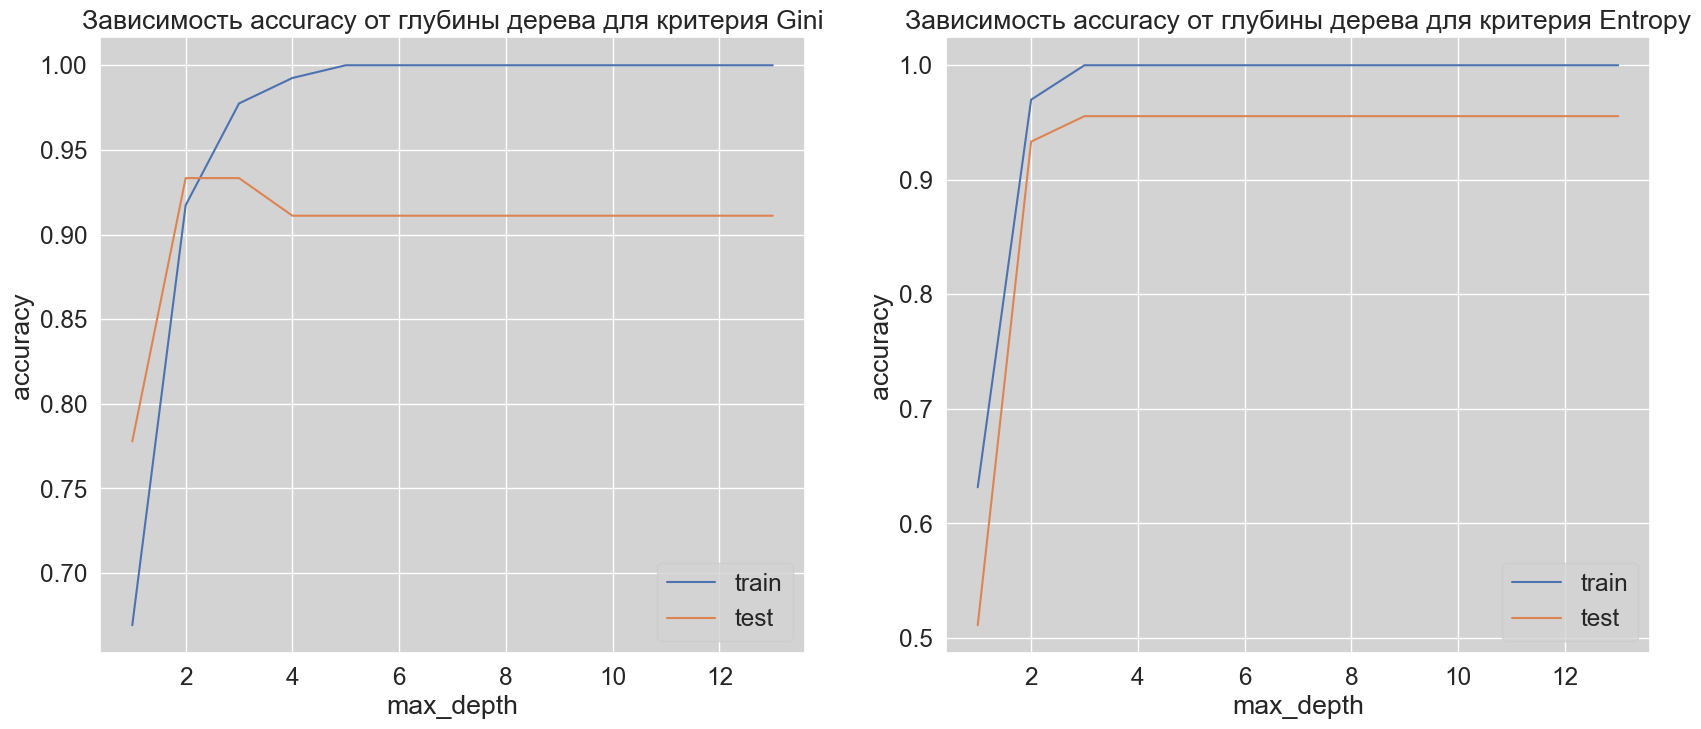

In [41]:
# код построения графиков
max_depth = np.arange(13) + 1
min_samples_split = 2 # лучший найденный гиперпараметр по gridsearch

classification_criteria = [gini_criterion, entropy_criterion]
criterion_names = ['Gini', 'Entropy']

plt.figure(figsize=(20, 8))
i = 0
for criterion, criterion_name in zip(classification_criteria, criterion_names):
    accuracy_train = []
    accuracy_test = []
    for j in (max_depth):
        model = DecisionTreeClassifier(criterion=criterion, max_depth=j, min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        accuracy_train.append(accuracy_score(model.predict(X_train), y_train))
        accuracy_test.append(accuracy_score(model.predict(X_test), y_test))
    plt.subplot(1, 2, i + 1)
    plt.plot(max_depth, accuracy_train, label='train')
    plt.plot(max_depth, accuracy_test, label='test')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title(f'Зависимость accuracy от глубины дерева для критерия {criterion_name}')
    i += 1

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**

Видно, что для обоих критериев значения качества на обучающих выборках довольно быстро сходятся к 1. Значения качества на тестовых выборках также довольно быстро сходятся к каким-то числам, которые в целом показывают очень хорошую точность, то есть несмотря на то, что значения качества на обучающей выборке с какого то момента равно 1, переобучения не возникает.

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите `r2_score`. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [47]:
boston_X, boston_y = load_boston(return_X_y=True)

In [48]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['MSE', 'MAE']

Разобьём выборку на обучение и тест.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, test_size=0.25, random_state=26)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [50]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    parameters_grid = {
        'max_depth' : np.arange(2, 10),
        'min_samples_split' : np.arange(2, 10)
    }
    
    model = DecisionTreeRegressor(criterion=criterion)
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=25)
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=parameters_grid,
        scoring='r2',
        cv=ss,
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    
    print('Результаты с помощью критерия {}:'.format(criterion_name))
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = gs.best_params_['max_depth']
    optimal_min_samples_split = gs.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    accuracy = r2_score(gs.predict(X_test), y_test)
    print(f'r2_score на тесте: {accuracy:.3f}')
    print()

Результаты с помощью критерия MSE:
Оптимальный max_depth: 6
Оптимальный min_samples_split: 9
r2_score на тесте: 0.751

Результаты с помощью критерия MAE:
Оптимальный max_depth: 5
Оптимальный min_samples_split: 9
r2_score на тесте: 0.684



Здесь же значения качества на тестовой выборке получилсь не такие хорошие -  0.751 и 0.684 соответственно. Также здесь совершенно другие оптимальные гиперпараметры, что и логично, тк мы решаем задачу регрессии , а не классификации.

**Построение графиков.**

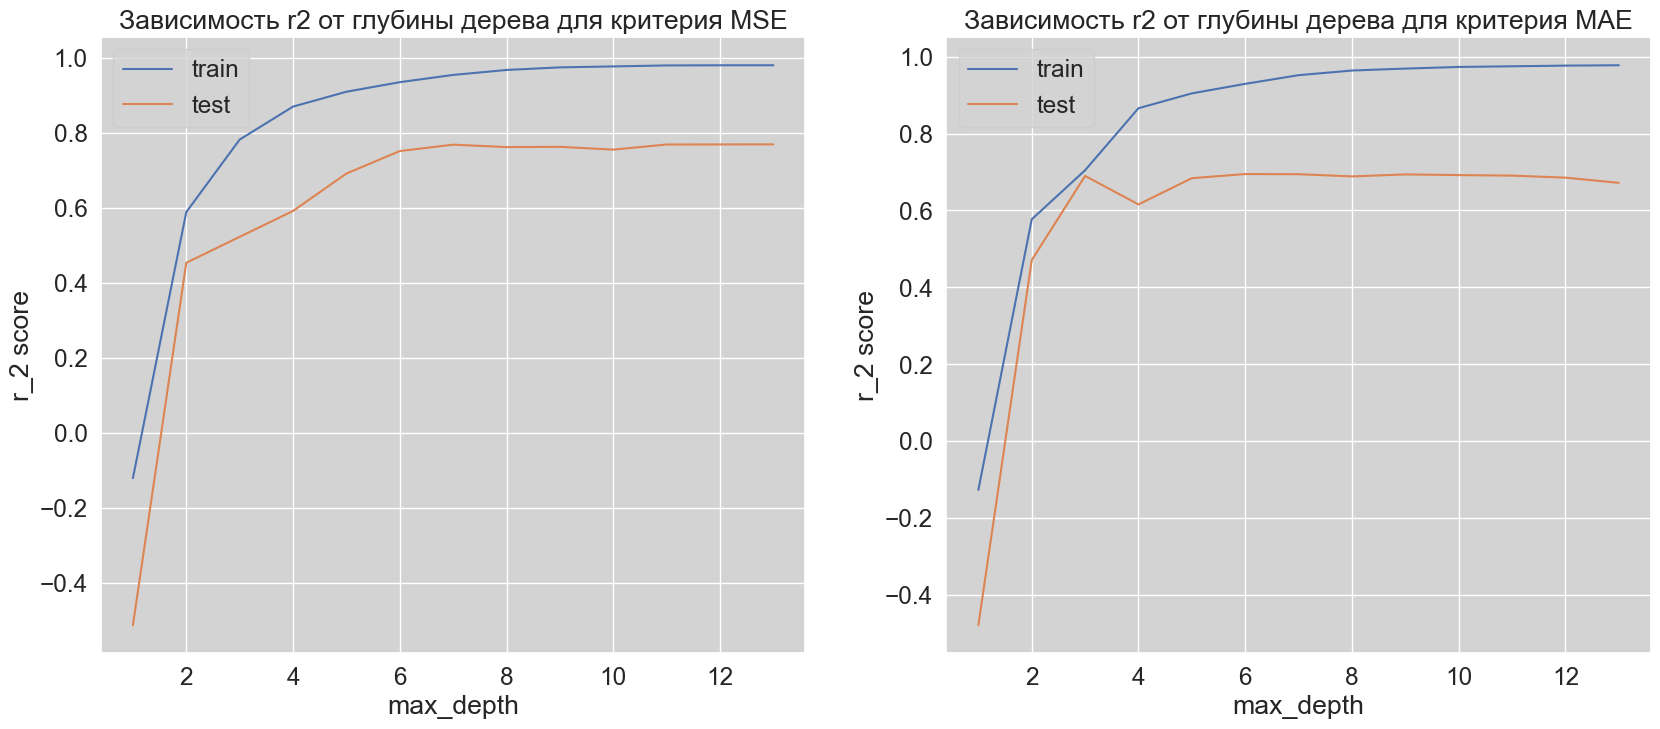

In [51]:
# код построения графиков
max_depth = np.arange(13) + 1
min_samples_split = 9 # лучший найденный гиперпараметр по gridsearch 

regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['MSE', 'MAE']

plt.figure(figsize=(20, 8))
i = 0
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    r2_train = []
    r2_test = []
    for j in (max_depth):
        model = DecisionTreeRegressor(criterion=criterion, max_depth=j, min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        r2_train.append(r2_score(model.predict(X_train), y_train))
        r2_test.append(r2_score(model.predict(X_test), y_test))
    plt.subplot(1, 2, i + 1)
    plt.plot(max_depth, r2_train, label='train')
    plt.plot(max_depth, r2_test, label='test')
    plt.xlabel('max_depth')
    plt.ylabel('r_2 score')
    plt.legend()
    plt.title(f'Зависимость r2 от глубины дерева для критерия {criterion_name}')
    i += 1

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

Значения критерия качетсва на обучающей выборке также как и в предыдущем случае с какого то момента стремится к 1. Но при этом качество на тестовой выборке получается хуже, чем в предыдущем случае (при классификации). Можно предположить, что возникает переобучение, но параметр min_samples_split = 9, то есть довольно не маленький по сравнению с размером данных (около 300 объектов).

Рассмотрим процесс ветвления. Если в узел пришло $n$ объектов, то мы считаем $n * d$ разбиений ($d$ -  количество признаков) и для каждого разбиения считаем информативность за $O(n)$. На каждой высоте мы рассматриваем не более $N$ объектов ($N$ -  количество всех объектов). Тогда получаем, что наш алгоритм работает за $O(h * N^2 * d)$, где $h$ - высота дерева. Чтобы услучшить наш алгоритм можем воспользоваться динамическим программированием. Для этого можно отсортировать объекты по одному из признаков и будем хранить нужные значения для пересчета информативности. Тогда вместо того, чтобы считать инофрмативность за $O(n)$ мы будем ее считать за $O(1)$. Также мы потратим $log(N)$ на сортировку, но итоговая сложность все равно получится лучше - $O(h * N * log(N) * d)$ вместо $O(h * N^2 * d)$.

## Задача 5

В этой задаче вам предстоит освоиться с обработкой пропусков в решающих деревьях, реализованной ранее.

Рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [ ]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [ ]:
adult_df = pd.read_csv('adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [ ]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [ ]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [ ]:
np.sum(adult_df.isnull(), axis=0)

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [ ]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [ ]:
<...>

Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [ ]:
<...>

**Вывод.**

<...>